# Introduction

In this project it is going to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data. 

The method applied is a random forest classifier fitted using the three components of linear acceleration with the rate of change of acceleration (Jerk).

For each three components of the acceleration and Jerk it is calculated the root mean squared (RMS), mean and median. These features are used to fit the random forest classifier using `train_time_series.csv` and predict the type of physical of the `test_time_series.csv`

# Methods

## 1. Libraries

In this section it will be imported the following libraries:

- `time`:  It is used to measure the runtime of this algorithm
- `numpy`: It is used to operate the dataset read.
- `pandas`: It is used to read time series in csv format.
- `scipy.stats`: It is used to calculate RMS and median.
- `matplotlib`: It is used to plot data extracted form time series.
- `sklearn`: It is used to import the random forest classifier algorithm and statics measures from this data.

In [1]:
##########Time Counter##########
import time
#start timestamp
t0 = time.time()


##################Library importation#################

#Maths, Data manage and Statistics
import numpy as np
import pandas as pd
import scipy.stats as ss

#Graphics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#Classifier Technics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## 2. FUNCTIONS

In this section, it is defined the functions to use in the classification algorithm.

- `extract_data`: Create a new dataframe from specific columns of the dataset read from the original time series.
- `plot_data`: Using a specific column for the x axis is plot three components of the acceleration of Jerk
- `dif_data`: Determinate the numeric derivate of a column set, grouping the time series for 1 second.
- `FEAT_data`: Determinate the RMS, mean and median for each 1 second time period in the column sends to the function.
- `accuracy`: Determinate the accuracy of the classifier using two different data set. First is using for training and second is using for valid.

In [2]:
def extract_data(df,cols,cl = 0,cols1 = []):
    """Extract a set of specific columns from a dataframe, 
        you could rename the columns of the subdataframe extracted"""
    
    if cl == 0:
        #Extract dataframe in the specific columns
        return(df[cols].copy())
    else:
        df1=df[cols].copy()
        #Dictionary for the columns name replacement
        diccol=dict(zip(cols,cols1))
        return(df1.rename(columns=diccol))
    
def plot_data(df1,auxdl,col_time,cols_df,lbtitle,fgsize):
    """Plotting for three specific columns from a dataframe respect to 
    a specific column (commonly timestamp). Each data is labeled according 
    four physics activities. """
    
    #Expand labels for each data
    dl = np.kron(np.array(auxdl).reshape(-1,1), np.ones((10, 1))).squeeze()
    #List of color for each physics activity
    colors = ['red','green','blue','purple']
    #Label for each physics activity
    llabels= ["standing","walking","staris down","stairs up"]
    #Figure with data received
    plt.figure(figsize=fgsize)
    plt.subplot(311)
    plt.title(lbtitle)
    scatter=plt.scatter(np.array(df1[col_time]), np.array(df1[cols_df[0]]), c=dl, cmap=ListedColormap(colors))
    plt.xlabel("x")
    plt.legend(handles=scatter.legend_elements()[0],labels=llabels,loc="lower right")
    plt.subplot(312)
    scatter=plt.scatter(np.array(df1[col_time]), np.array(df1[cols_df[1]]), c=dl, cmap=ListedColormap(colors))
    plt.xlabel("y")
    plt.legend(handles=scatter.legend_elements()[0],labels=llabels,loc="lower right")
    plt.subplot(313)
    scatter=plt.scatter(np.array(df1[col_time]), np.array(df1[cols_df[2]]), c=dl, cmap=ListedColormap(colors))
    plt.xlabel("z")
    plt.legend(handles=scatter.legend_elements()[0],labels=llabels,loc="lower right")
    plt.show()
    return

def dif_data(df,col_time,cols_df,cols_dfinte,lf):
    """Determinate derived respect to time from the data. 
    The initial point for the discrete derived is restarted for each period of 
    sample of each specific activity (One second in this case)"""
    
    (rdf,cdf)=df.shape
    #Pre-initialization of the output dataframe
    indexdif=list(df.index)    
    dfdif=pd.DataFrame(data=np.zeros((rdf,cdf)),index=indexdif,columns=([col_time]+cols_df))
    dfdif[col_time]=df[col_time]
    
    ridini=0
    for j,cid in enumerate(cols_df):
        for i,rid in enumerate(lf[col_time]):
            #Extraction of the data for 1 second
            if i==0:
                auxdata=df[cid][df[col_time]<=rid]
                t0=rid-100    
            else:
                auxdf=df[df[col_time]>ridini]
                auxdata=auxdf[cid][auxdf[col_time]<=rid]
            #Restart the initial point for numeric derivated 
            x0=auxdata.iloc[0]
            for label, x in auxdata.items():
                t1=df[col_time][label]
                dfdif[cid][label] = (x-x0)/((t1-t0)/1000)
                t0=t1
                x0=x
            ridini=rid    
            
    return dfdif.rename(columns=dict(zip(cols_df,cols_dfinte)))


def FEAT_data(df1,cols_df,lf,col_lf):
    """Determinate the RMS (Root mean square), mean and median for each column 
    in the dataframe given. The rows of each column are grouped respect to 
    sample time of the physical activity (10 timestamps or 1 second)"""
    #Dataframe size    
    (rdf,cdf)=df1.shape
    (rlf,clf)=lf.shape
    
    #Combination list for the feature labels and the column labels
    indexdfF=list(lf.index)
    lF=["RMS","Mean","Median"]
    cols_dfF=list()
    for char1 in cols_df:
        for char2 in lF:
            cols_dfF.append(char1+char2)
            
    dfF=pd.DataFrame(data=np.zeros((rlf,len(cols_dfF))),index=indexdfF,columns=list(cols_dfF))
    ridini=0
    for cid in cols_df:
        for i,rid in enumerate(lf[col_lf]):
            #Extraction of the data for 1 second
            if i==0:
                auxdata=np.array(df1[cid][df1[col_lf]<=rid])
            else:
                auxdf1=df1[df1[col_lf]>ridini]
                auxdata=np.array(auxdf1[cid][auxdf1[col_lf]<=rid])
            ridini=rid
            #Determinate the feature for the group data extracted
            for cid1 in cols_dfF:
                if cid1==(cid+"RMS"):
                    dfF[cid1][indexdfF[i]]=np.sqrt(np.dot(auxdata,auxdata)/auxdata.size)
                if cid1==(cid+"Mean"):
                    dfF[cid1][indexdfF[i]]=np.mean(auxdata)
                if cid1==(cid+"Median"):
                    dfF[cid1][indexdfF[i]]=ss.median_absolute_deviation(auxdata)
    return dfF

def accuracy(estimator, X, y,X_val,y_val):
    """Determine accuracy for the prediction of the outcomes (y_valid), 
    using an specific classificator, training with an specific data (X) and outcomes (y)."""
    
    predictions = estimator.fit(X, y).predict(X_val)
    return accuracy_score(y_val, predictions)

## 3. Data Reading
    
In this section the training time series is read from `train_time_series.csv`.

The Smartphone accelerometers sample the three components of each 0.1 second, and the physical activity is labeled for each 1 second. For this reason the first 4 rows of the training dataset is deleted.

In [3]:
train_ts = pd.read_csv("train_time_series.csv", index_col=0)
train_l = pd.read_csv("train_labels.csv", index_col=0)

#Delete four rows
train_ts = train_ts.drop([20586,20587,20588,20589],)
train_l = train_l.drop([20589])

#Show the data reading
print(train_ts.head(),"\n",train_ts.shape)
print(train_l.head(),"\n",train_l.shape)

           timestamp                 UTC time accuracy         x         y  \
20590  1565109931188  2019-08-06T16:45:31.188  unknown -0.054031 -1.003616   
20591  1565109931288  2019-08-06T16:45:31.288  unknown -0.010880 -0.967575   
20592  1565109931388  2019-08-06T16:45:31.388  unknown  0.052841 -0.982330   
20593  1565109931488  2019-08-06T16:45:31.488  unknown  0.032974 -1.053207   
20594  1565109931589  2019-08-06T16:45:31.589  unknown -0.090424 -0.972794   

              z  
20590  0.126450  
20591  0.170898  
20592  0.235565  
20593  0.256714  
20594  0.356308   
 (3740, 6)
           timestamp                 UTC time  label
20599  1565109932090  2019-08-06T16:45:32.090      1
20609  1565109933092  2019-08-06T16:45:33.092      1
20619  1565109934094  2019-08-06T16:45:34.094      1
20629  1565109935097  2019-08-06T16:45:35.097      1
20639  1565109936099  2019-08-06T16:45:36.099      1 
 (374, 3)


## 4. Dataset Extraction
    
In this part it is extract the three components of the acceleration on axes `x`, `y` and `z`

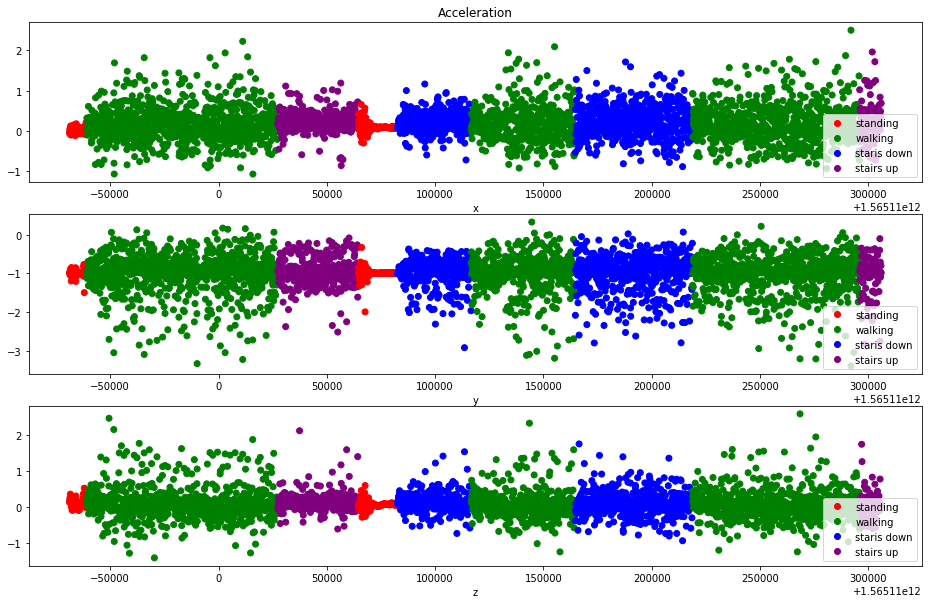

In [4]:
#Labels for timestamps column
lf_train=extract_data(train_l,["timestamp","label"])

#Aceleration
dfa_train=extract_data(train_ts,["timestamp","x","y","z"],1,["timestamp","ax","ay","az"])
plot_data(dfa_train,lf_train["label"],"timestamp",["ax","ay","az"],"Acceleration",(16,10))

## 5. Acceleration rate of change (Jerk)

The acceleration by it self can not be identify the physical activity, for these reason i decided to determinate the rate of change for the acceleration time series.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


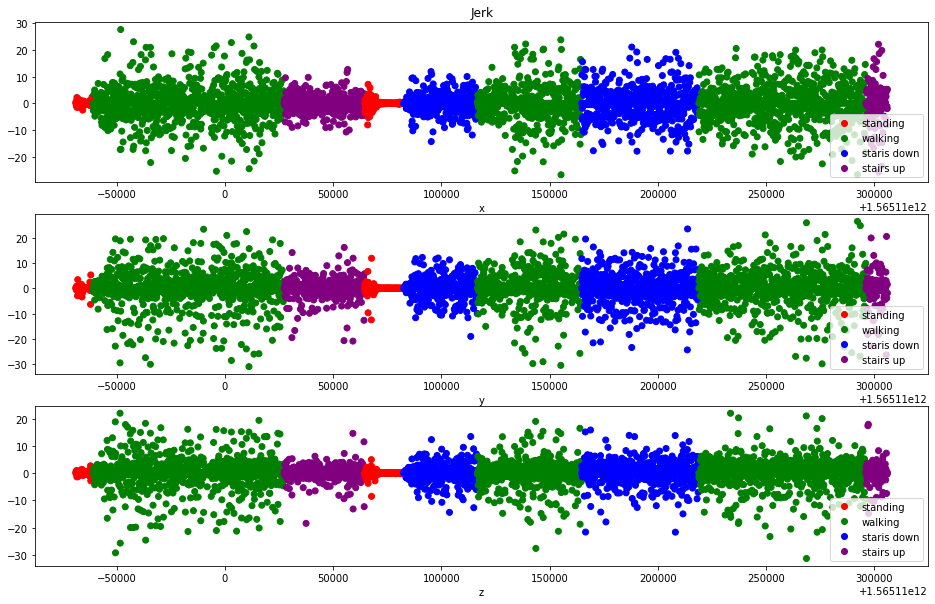

In [5]:
#Acceleration rate of change (Jerk)
dfap_train=dif_data(dfa_train,"timestamp",["ax","ay","az"],["axp","ayp","azp"],lf_train)
plot_data(dfap_train,lf_train["label"],"timestamp",["axp","ayp","azp"],"Jerk",(16,10))

## 6. Norm of Acceleration and Jerk 

This section determinate the Norm of the Acceleration and Jerk to add to the dataset for the classifier.

In [6]:
#Norm of acceleration
dfa_train["A"]=np.sqrt(np.square(dfa_train["ax"])+np.square(dfa_train["ay"])+np.square(dfa_train["az"]))
#Norm of Jerk
dfap_train["Ap"]=np.sqrt(np.square(dfap_train["axp"])+np.square(dfap_train["ayp"])+np.square(dfap_train["azp"]))

## 7. Features for Acceleration and Jerk

Using the norm and thre component of the acceleration and Jerk, it is determinated the RMS, mean and median for each 1 second period of time.

This dataset is used for fiting the classifier.

In [7]:
dfaj_train=dfa_train
dfaj_train[["axp","ayp","azp","Ap"]]=dfap_train[["axp","ayp","azp","Ap"]]
dfF_train=FEAT_data(dfaj_train,["ax","ay","az","A","axp","ayp","azp","Ap"],lf_train,"timestamp")
print("Acceleration and Jerk FEATURES:",dfF_train.head())

Acceleration and Jerk FEATURES:           axRMS    axMean  axMedian     ayRMS    ayMean  ayMedian     azRMS  \
20599  0.070870 -0.015561  0.091475  0.976351 -0.971701  0.106496  0.211816   
20609  0.094813  0.080754  0.025439  1.001906 -1.001831  0.012465  0.061450   
20619  0.082608 -0.005792  0.073433  1.010009 -1.005200  0.087663  0.161120   
20629  0.081950  0.039366  0.052903  0.999043 -0.998077  0.008506  0.096214   
20639  0.062373  0.058824  0.021695  1.003975 -1.003946  0.004604  0.064572   

         azMean  azMedian      ARMS  ...  axpMedian    aypRMS   aypMean  \
20599  0.189870  0.094020  1.001573  ...   0.958975  1.496227  0.147028   
20609 -0.047028  0.032158  1.008256  ...   0.454471  0.200438 -0.019221   
20619  0.108311  0.176027  1.026110  ...   0.411507  1.256686 -0.200067   
20629  0.060002  0.110320  1.007005  ...   0.599389  0.653364 -0.114185   
20639 -0.051945  0.029602  1.007981  ...   0.381294  0.125010  0.002252   

       aypMedian    azpRMS   azpMean  azpM

## 8. Classifier Fitting

In this section we use the features determinated in previous section as input data for an random forest classifier, and outcomes are gotten from `train_labels.csv`.

In order to verify the accuracy of the fitting, it is previously splitted in a subset data to training and other subset to verify the classifier fitting.

Next, we present the accuracy of the random forest classifier for the training subset data, and next the accuracy for the other subset data that were not used in the fitting.

Finally, we fit again the random forest classifier with all dataset.

In [8]:
#Input data and outcomes for training
X=dfF_train.copy()
y = lf_train["label"]    
print("Input data skews: \n",X.skew() )

#Classifier 
forest_classifier = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)

#Data spliting
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=1, shuffle = True)



#Classifier fiting
acu_train = accuracy(forest_classifier,X_train,y_train,X_train,y_train)
print("\nTraining accuracy: ",acu_train)

#Precisión con datos de validación
acu_valid = accuracy(forest_classifier,X_train,y_train,X_valid,y_valid)
print("\nValidation accuracy: ",acu_valid)

#Fitting for each dataset
forest_classifier.fit(X,y);

Input data skews: 
 axRMS        0.132311
axMean      -0.015270
axMedian     0.617815
ayRMS        0.806901
ayMean      -0.356436
ayMedian     0.232441
azRMS        0.629129
azMean      -0.254592
azMedian     0.507984
ARMS         0.783344
AMean        0.661041
AMedian      0.062190
axpRMS       0.391537
axpMean     -0.551429
axpMedian    0.584634
aypRMS       0.177668
aypMean     -0.019668
aypMedian    0.449563
azpRMS       0.704572
azpMean      0.175103
azpMedian    0.905077
ApRMS        0.096983
ApMean      -0.063491
ApMedian     0.539992
dtype: float64

Training accuracy:  1.0

Validation accuracy:  0.8157894736842105


# Results

## Predictions for a new time series data
    
In this section it is used the steps `3-8` form "METHOD" section to predict the physical activity performed in `test_time_series.csv`.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Test Skews: 
 axRMS        0.292258
axMean      -0.008103
axMedian     0.939004
ayRMS        0.890049
ayMean      -0.158636
ayMedian     0.087464
azRMS        0.605378
azMean      -0.171853
azMedian     0.077556
ARMS         1.201464
AMean        0.980928
AMedian      0.085921
axpRMS       0.748744
axpMean      0.192549
axpMedian    0.921338
aypRMS       0.343409
aypMean     -0.313299
aypMedian    0.673816
azpRMS       0.723393
azpMean      0.088117
azpMedian    0.350750
ApRMS        0.315989
ApMean       0.156720
ApMedian     0.765264
dtype: float64


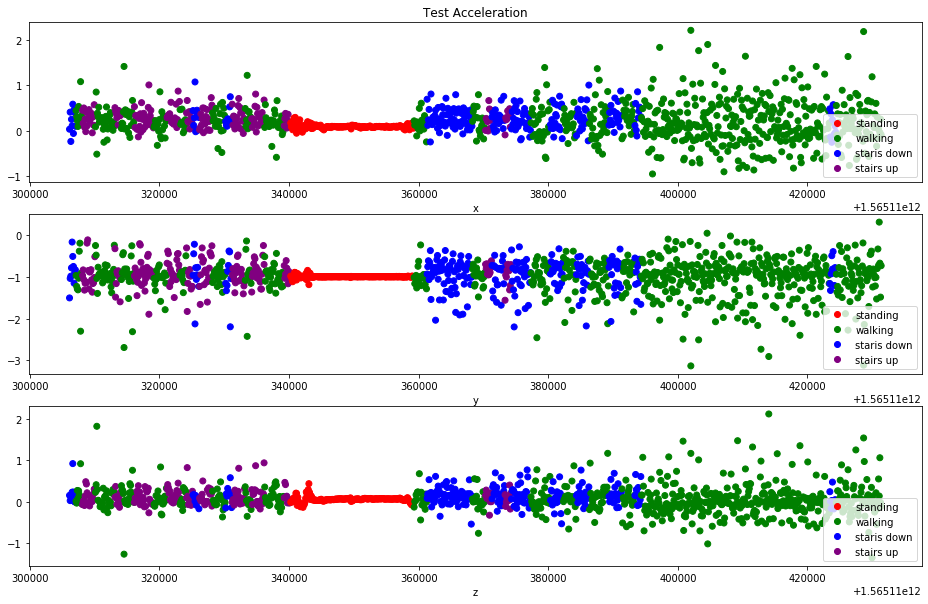

In [9]:
#READ DATA
test_ts = pd.read_csv("test_time_series.csv", index_col=0)
test_l = pd.read_csv("test_labels.csv", index_col=0)    

#DATA EXTRACTION 
#Labels
lf_test=extract_data(test_l,["timestamp","label"])

#Aceleration
dfa_test=extract_data(test_ts,["timestamp","x","y","z"],1,["timestamp","ax","ay","az"])

#DETERMINATION
#Jerk
dfap_test=dif_data(dfa_test,"timestamp",["ax","ay","az"],["axp","ayp","azp"],lf_test)

#Norm of acceleration
dfa_test["A"]=np.sqrt(np.square(dfa_test["ax"])+np.square(dfa_test["ay"])+np.square(dfa_test["az"]))
#Norm of Jerk
dfap_test["Ap"]=np.sqrt(np.square(dfap_test["axp"])+np.square(dfap_test["ayp"])+np.square(dfap_test["azp"]))


#Features for acceleration and Jerk
dfaj_test=dfa_test
dfaj_test[["axp","ayp","azp","Ap"]]=dfap_test[["axp","ayp","azp","Ap"]]
dfF_test=FEAT_data(dfaj_test,["ax","ay","az","A","axp","ayp","azp","Ap"],lf_test,"timestamp")

#CLASIFICATION
#Input data and outcomes
X_test =dfF_test.copy()
print("Test Skews: \n",X_test.skew() )

#Prediction
y_test_pred = forest_classifier.predict(X_test)
y_test_pred=y_test_pred.reshape(-1,1)

#Save predictions
lf_test["label"] = y_test_pred
lf_test.to_csv('test_labels_predicted.csv')


#PLOTING
#Acceleration
plot_data(dfa_test,y_test_pred,"timestamp",["ax","ay","az"],"Test Acceleration",(16,10))
#Jerk
#plot_data(dfap_test,y_test_pred,"timestamp",["axp","ayp","azp"],"Test Jerk",(16,10))

# RUNTIME

The runtime for the classification es:

In [10]:
#Show the program runtime
print("Elapsed time:",time.time()-t0)

Elapsed time: 14.992878913879395


# Conclutions

- The physical activity cannot be classified with a high accuracy using just three components of the linear acceleration.
- The time series given has lot of noise, it is necessary to eliminate the gravity effect using the 
gyroscope sensor to know the orientation of the mobile smartphone.
- The classifier fitted has an accuracy of 81.5% with the training data. However, the classifier applied to the test dataset has physical change in short periods of time (less than 1 second).
